In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [3]:
# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0] * X1 + beta[1] * X2 + np.random.randn(size) * sigma

Text(0.5, 0, 'X2')

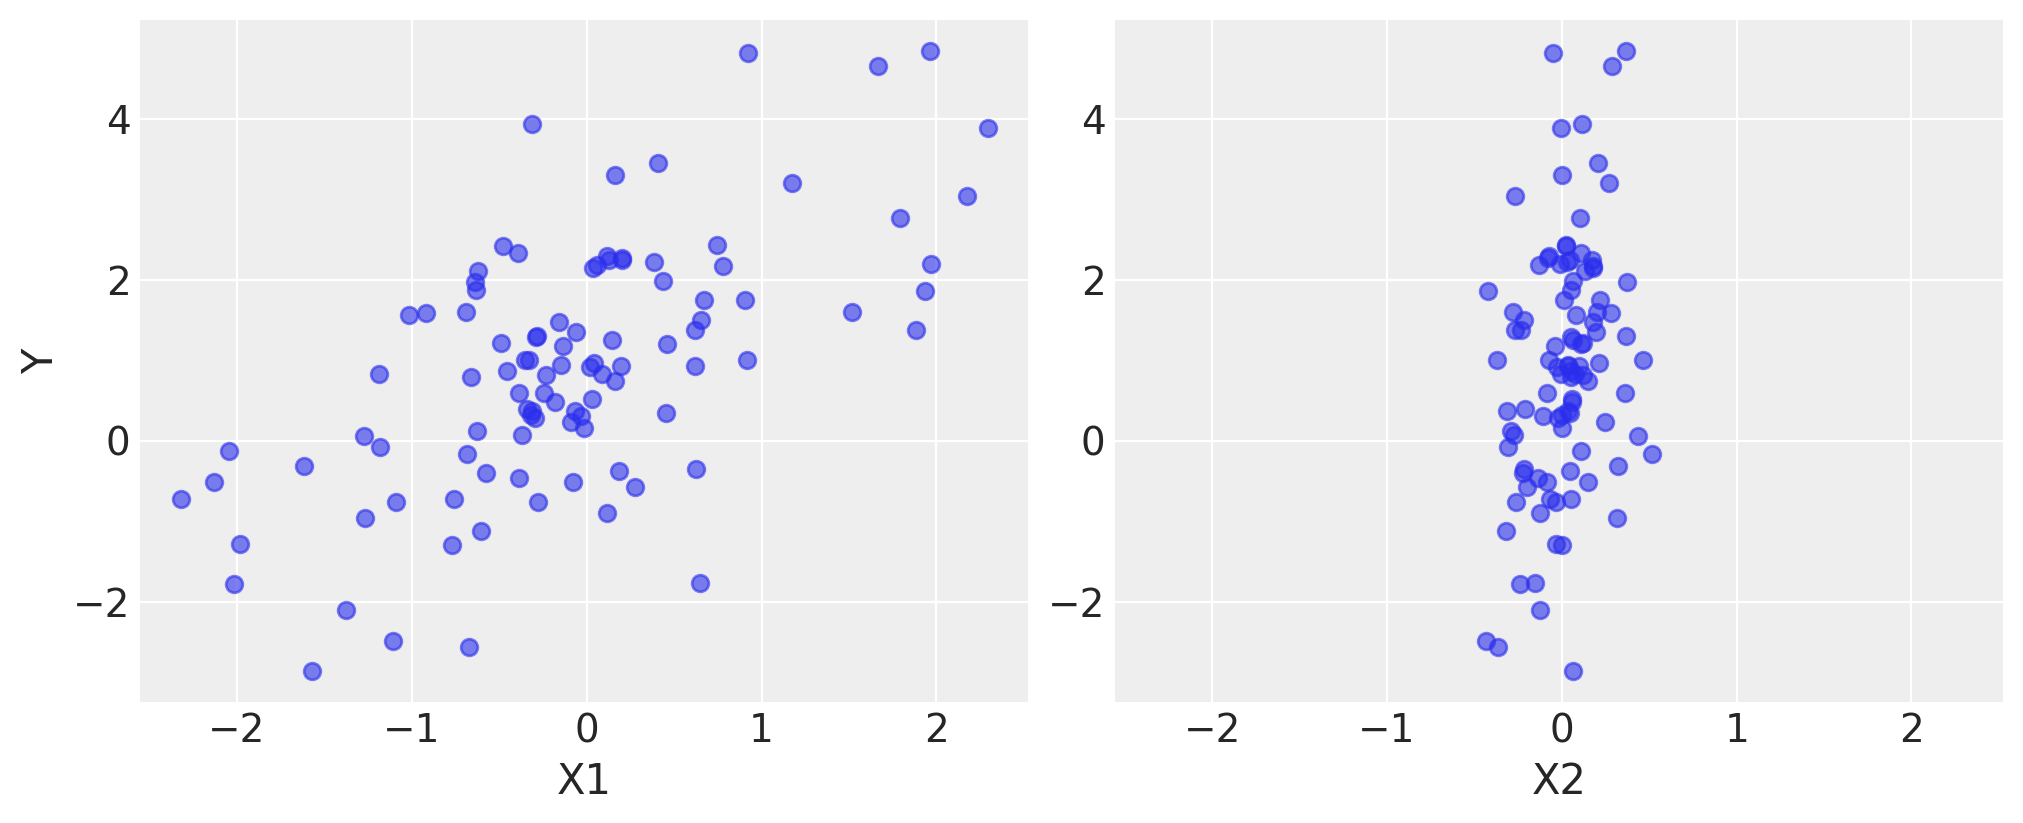

In [4]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 4))
axes[0].scatter(X1, Y, alpha=0.6)
axes[1].scatter(X2, Y, alpha=0.6)
axes[0].set_ylabel("Y")
axes[0].set_xlabel("X1")
axes[1].set_xlabel("X2")

In [5]:
import pymc as pm

print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v5.1.2


## Note if you have numba installed, cores has to be set to 1 otherwise model couldn't be unpickled. 

In [6]:
basic_model = pm.Model()

with basic_model:

    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10, shape=2) # beta is a vector of length 2
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of outcome. 
    # mu is a stochastic variable dependent on alpha, beta and sigma
    mu = alpha + beta[0] * X1 + beta[1] * X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

    # Use the Metropolis-Hastings algorithm to obtain samples from the posterior distribution
    trace = pm.sample(2000, tune=1000, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 17 seconds.


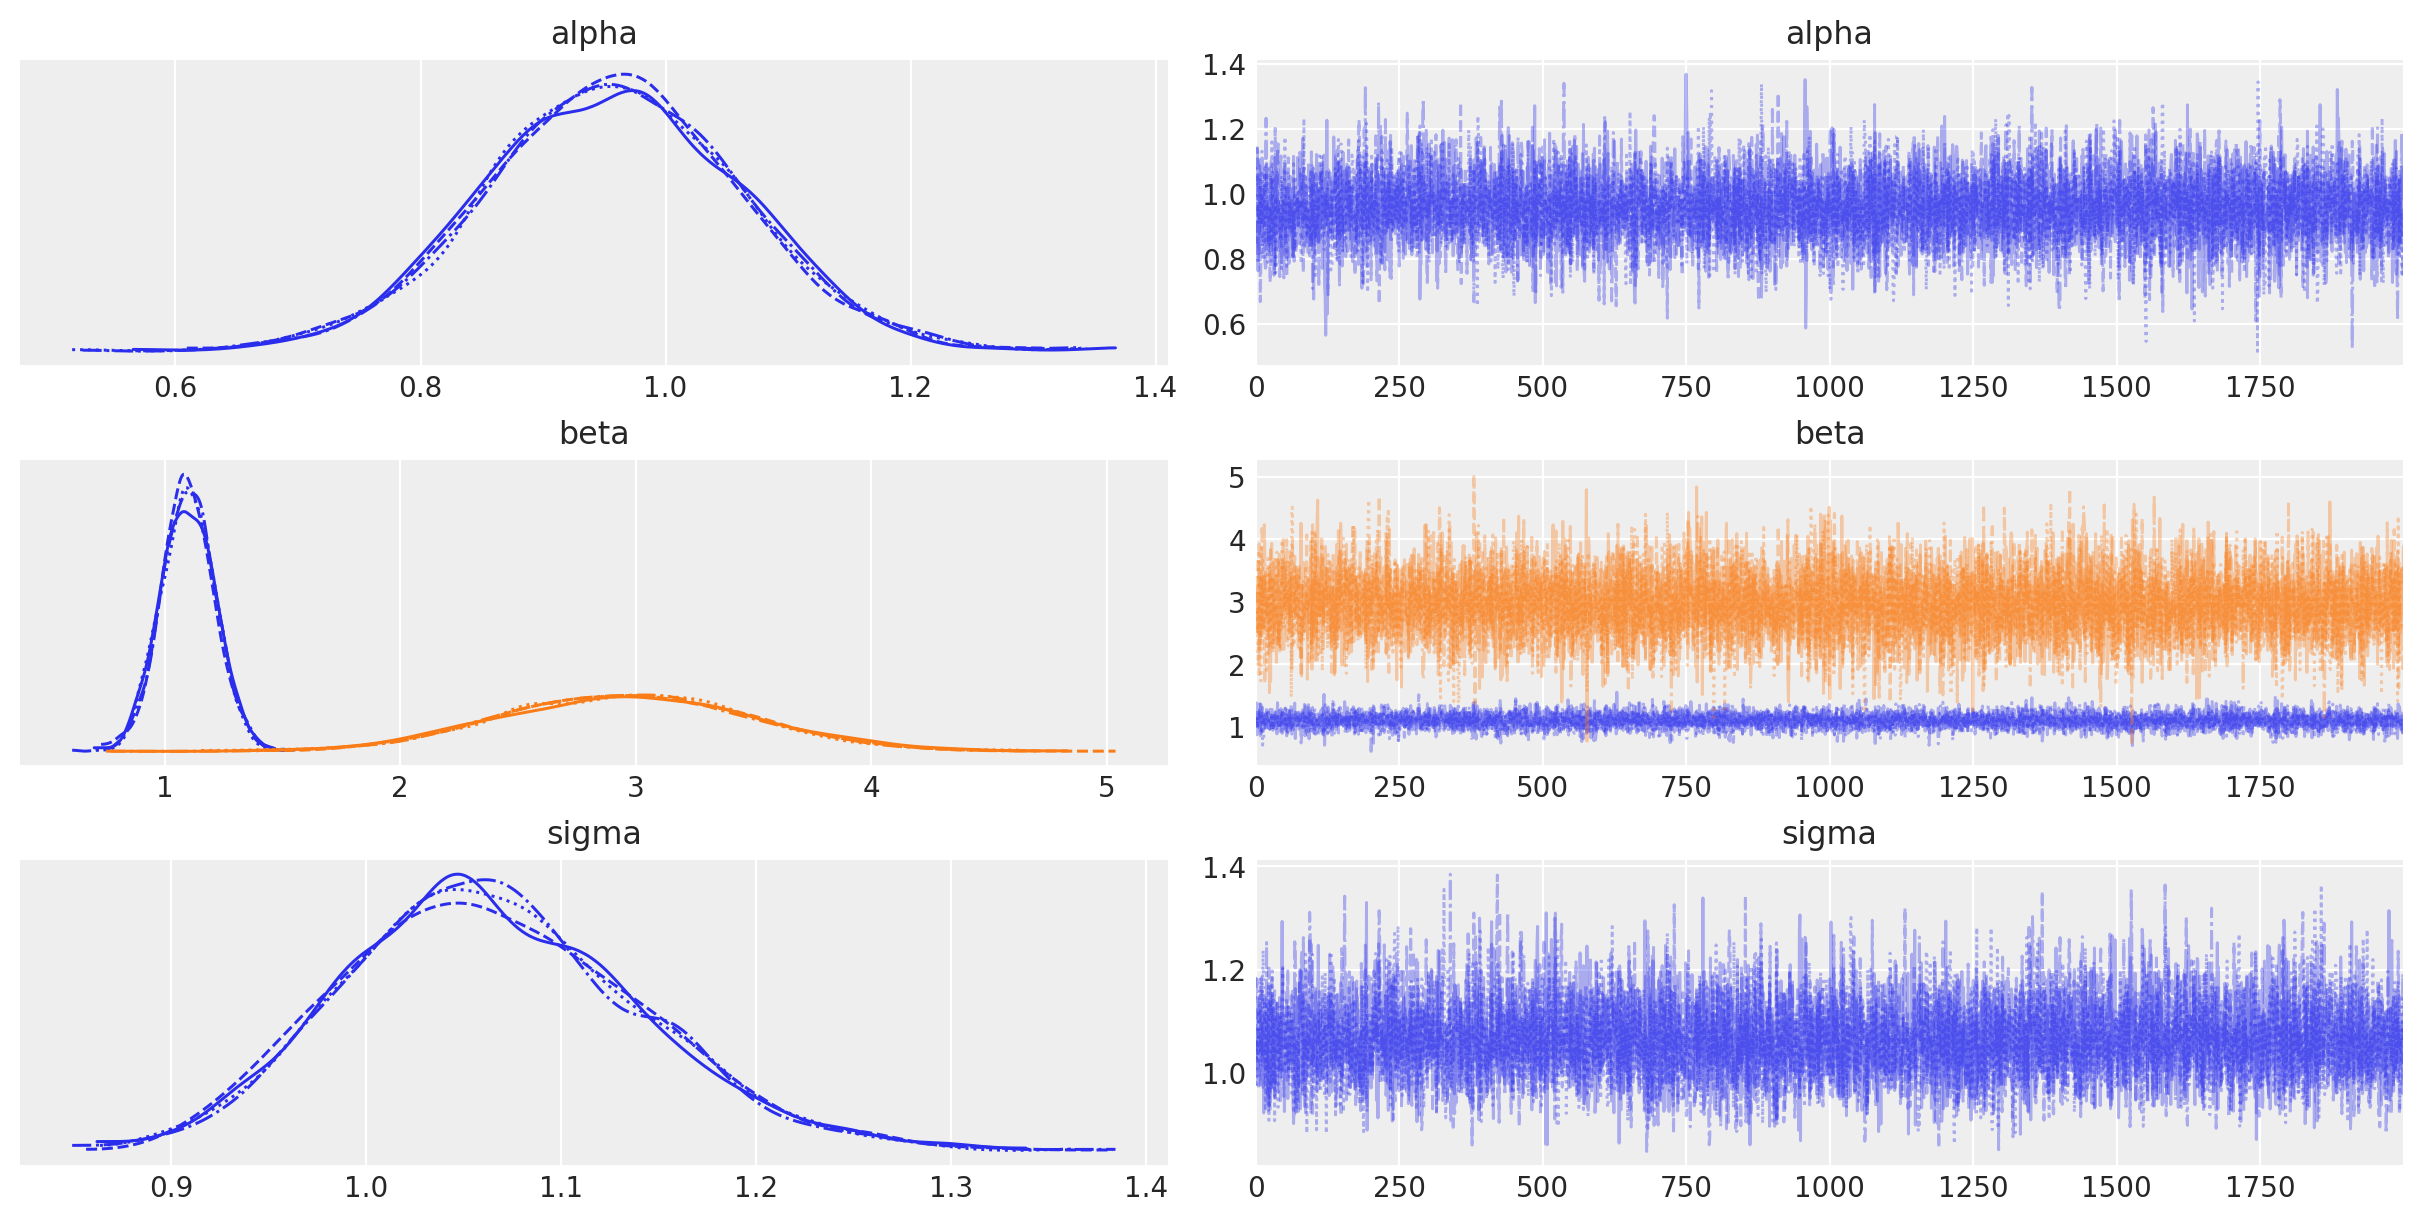

In [7]:
# Plot the posterior distributions of the coefficients and the error term
pm.plot_trace(trace)
plt.show()

In [8]:
trace.posterior

<xarray.Dataset>
Dimensions:     (chain: 4, draw: 2000, beta_dim_0: 2)
Coordinates:
  * chain       (chain) int64 0 1 2 3
  * draw        (draw) int64 0 1 2 3 4 5 6 ... 1994 1995 1996 1997 1998 1999
  * beta_dim_0  (beta_dim_0) int64 0 1
Data variables:
    alpha       (chain, draw) float64 0.9461 0.8086 1.139 ... 1.063 0.9803
    beta        (chain, draw, beta_dim_0) float64 1.247 2.583 ... 1.054 2.325
    sigma       (chain, draw) float64 1.075 1.07 1.068 ... 1.016 1.192 1.071
Attributes:
    created_at:                 2023-04-21T21:01:40.215330
    arviz_version:              0.15.1
    inference_library:          pymc
    inference_library_version:  5.1.2
    sampling_time:              16.75636100769043
    tuning_steps:               1000

In [9]:
az.summary(trace, var_names=["alpha", "beta", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.957,0.105,0.768,1.163,0.001,0.001,8453.0,6152.0,1.0
beta[0],1.099,0.114,0.882,1.313,0.001,0.001,7868.0,5463.0,1.0
beta[1],2.956,0.529,1.978,3.957,0.006,0.004,8536.0,5933.0,1.0
sigma,1.065,0.077,0.921,1.202,0.001,0.001,7671.0,5987.0,1.0


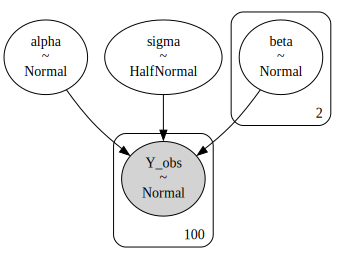

In [10]:
pm.model_to_graphviz(basic_model)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

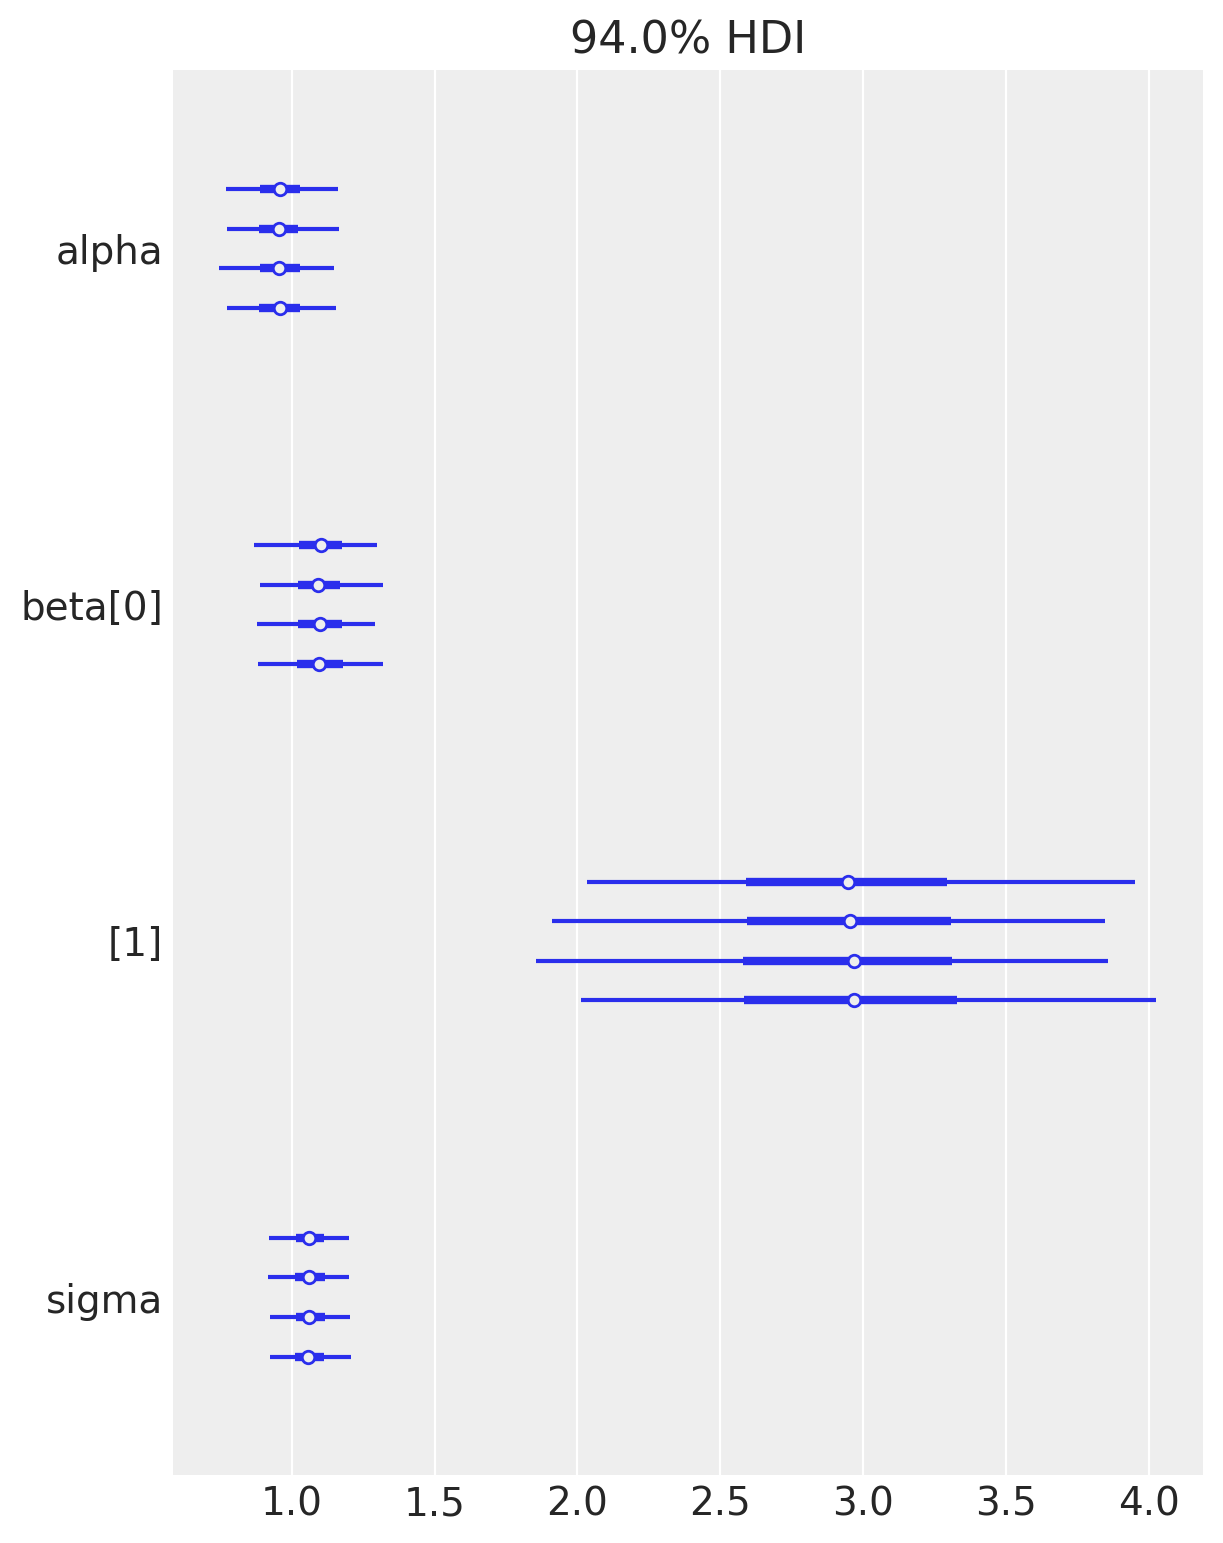

In [12]:
az.plot_forest(trace, var_names=["alpha", "beta", "sigma"])